In [1]:

# =====================================================
# 0. IMPORT LIBRARIES
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)


In [2]:

# =====================================================
# 1. DATA UNDERSTANDING
# =====================================================
df = pd.read_csv("C:/Users/syadi/Documents/Magang IDX Partners/loan_data_2007_2014.csv")

print("=== Info Data ===")
print(df.info())
print("\nJumlah baris dan kolom:", df.shape)

print("\n=== Statistik Deskriptif ===")
print(df.describe(include="all").transpose())

print("\n=== Distribusi Loan Status ===")
print(df['loan_status'].value_counts())

# Fokus hanya Fully Paid vs Charged Off/Default
df = df[df['loan_status'].isin(['Fully Paid','Charged Off','Default'])]
df['label'] = df['loan_status'].apply(lambda x: 0 if x=="Fully Paid" else 1)


C:\Users\syadi\AppData\Local\Temp\ipykernel_3588\815150580.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/syadi/Documents/Magang IDX Partners/loan_data_2007_2014.csv")


=== Info Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-

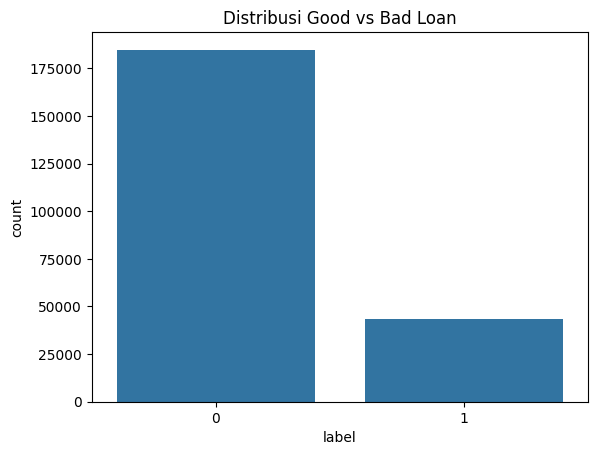

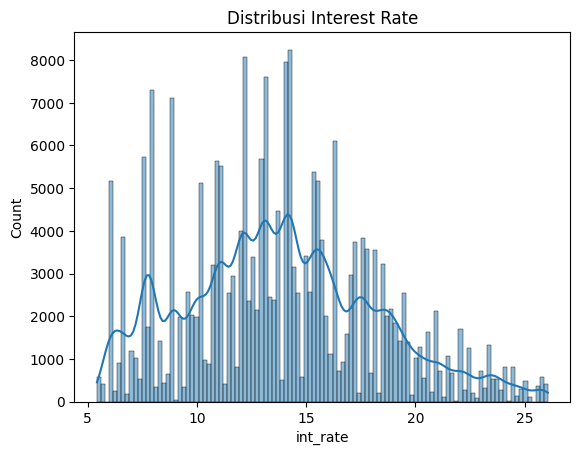

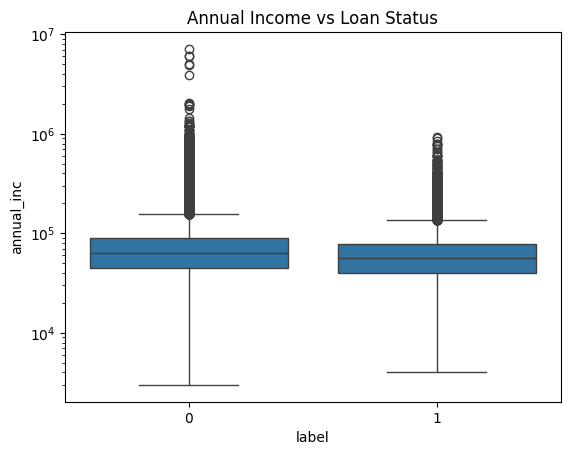

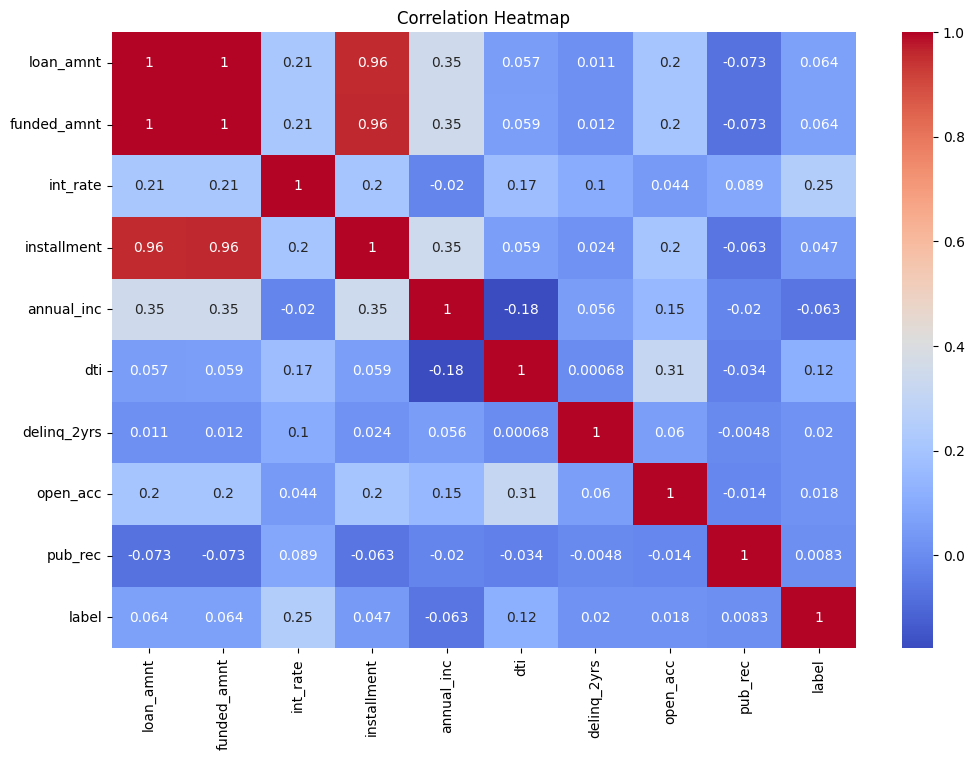

In [3]:

# =====================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# =====================================================

# Distribusi target
sns.countplot(x="label", data=df)
plt.title("Distribusi Good vs Bad Loan")
plt.show()

# Analisis univariat
sns.histplot(df["int_rate"], kde=True)
plt.title("Distribusi Interest Rate")
plt.show()

# Analisis bivariat
sns.boxplot(x="label", y="annual_inc", data=df)
plt.yscale("log")
plt.title("Annual Income vs Loan Status")
plt.show()

# Korelasi numerik
plt.figure(figsize=(12,8))
sns.heatmap(
    df[["loan_amnt","funded_amnt","int_rate","installment",
        "annual_inc","dti","delinq_2yrs","open_acc","pub_rec","label"]].corr(),
    annot=True, cmap="coolwarm"
)
plt.title("Correlation Heatmap")
plt.show()


In [4]:

# =====================================================
# 3. DATA PREPARATION
# =====================================================

features = [
    "loan_amnt","funded_amnt","term","int_rate","installment",
    "grade","sub_grade","emp_length","home_ownership","annual_inc",
    "verification_status","purpose","dti","delinq_2yrs",
    "inq_last_6mths","open_acc","pub_rec"
]
X = df[features]
y = df['label']

# Handle missing values
X = X.fillna({
    col: X[col].median() if X[col].dtype != 'object' else X[col].mode()[0]
    for col in X.columns
})

# Encoding kategori
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:

# =====================================================
# 4. DATA MODELLING
# =====================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}



=== Logistic Regression ===
              precision    recall  f1-score   support

   Good Loan       0.82      0.99      0.90     36948
    Bad Loan       0.55      0.04      0.07      8662

    accuracy                           0.81     45610
   macro avg       0.68      0.52      0.48     45610
weighted avg       0.77      0.81      0.74     45610



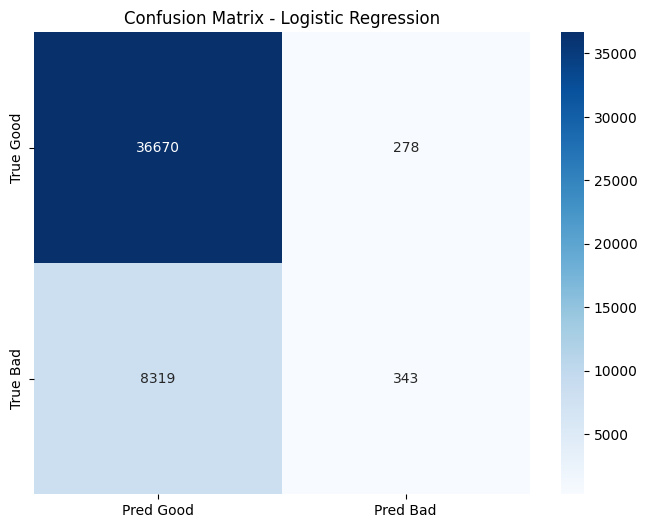


=== Decision Tree ===
              precision    recall  f1-score   support

   Good Loan       0.82      0.99      0.89     36948
    Bad Loan       0.52      0.05      0.09      8662

    accuracy                           0.81     45610
   macro avg       0.67      0.52      0.49     45610
weighted avg       0.76      0.81      0.74     45610



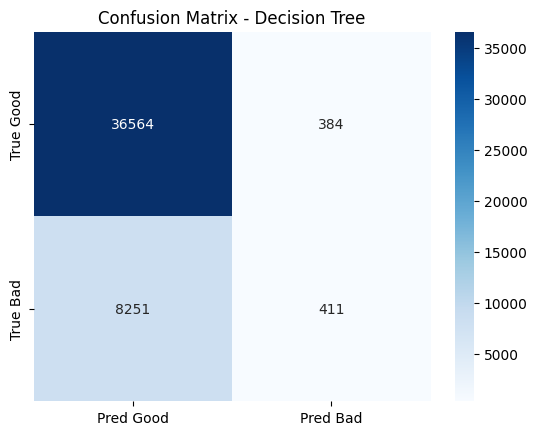


=== KNN ===
              precision    recall  f1-score   support

   Good Loan       0.82      0.93      0.87     36948
    Bad Loan       0.32      0.14      0.19      8662

    accuracy                           0.78     45610
   macro avg       0.57      0.53      0.53     45610
weighted avg       0.73      0.78      0.74     45610



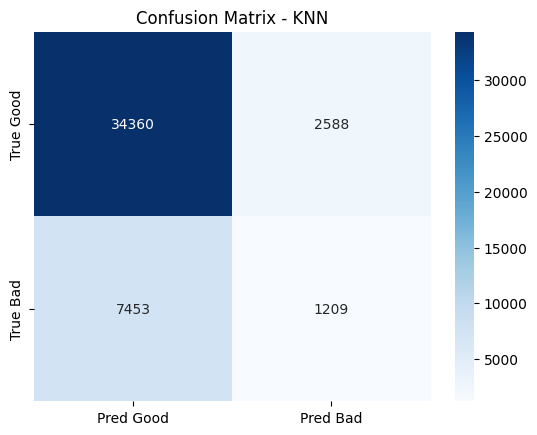


=== Random Forest ===
              precision    recall  f1-score   support

   Good Loan       0.82      0.98      0.89     36948
    Bad Loan       0.48      0.06      0.11      8662

    accuracy                           0.81     45610
   macro avg       0.65      0.52      0.50     45610
weighted avg       0.75      0.81      0.74     45610



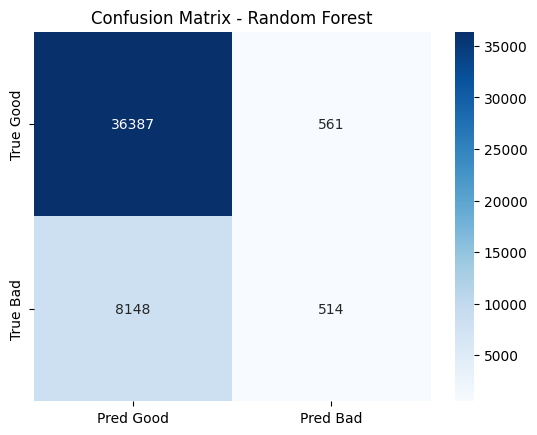

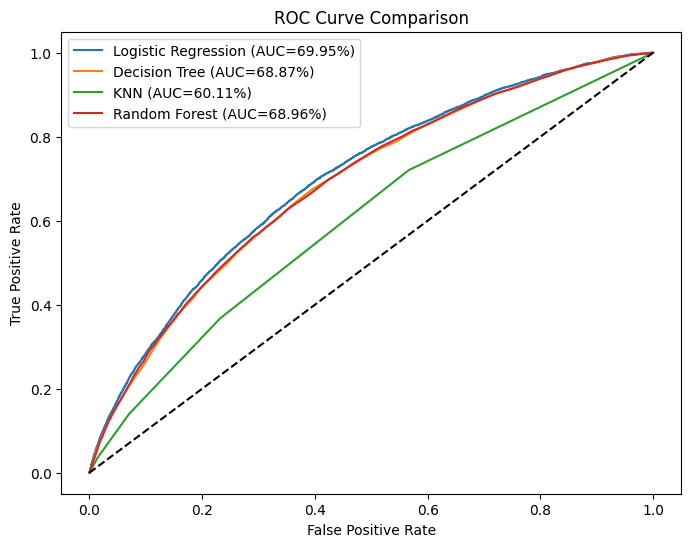

In [6]:

# =====================================================
# 5. EVALUATION
# =====================================================
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(8,6))  # ROC Curve Comparison

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    # Metrics
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    rec = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, y_prob) * 100
    cv_acc = cross_val_score(model, X_scaled, y, cv=cv, scoring="accuracy").mean() * 100

    results.append({
        "Model": name,
        "Accuracy (%)": acc,
        "Precision (%)": prec,
        "Recall (%)": rec,
        "F1-score (%)": f1,
        "ROC-AUC (%)": auc,
        "CV Accuracy (%)": cv_acc
    })

    # Classification Report
    print(classification_report(y_test, y_pred, target_names=["Good Loan", "Bad Loan"]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Pred Good", "Pred Bad"], 
                yticklabels=["True Good", "True Bad"])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

 # ROC Curve Comparison
plt.figure(figsize=(8,6))  # buat canvas sekali di awal

for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2%})")

# garis diagonal
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()



Top 10 Feature Importance:


,Feature,Importance
5,feature_5,0.115706
4,feature_4,0.105750
3,feature_3,0.094056
2,feature_2,0.092054
8,feature_8,0.079024
1,feature_1,0.074426
0,feature_0,0.074219
7,feature_7,0.039265
6,feature_6,0.021067
51,feature_51,0.015912


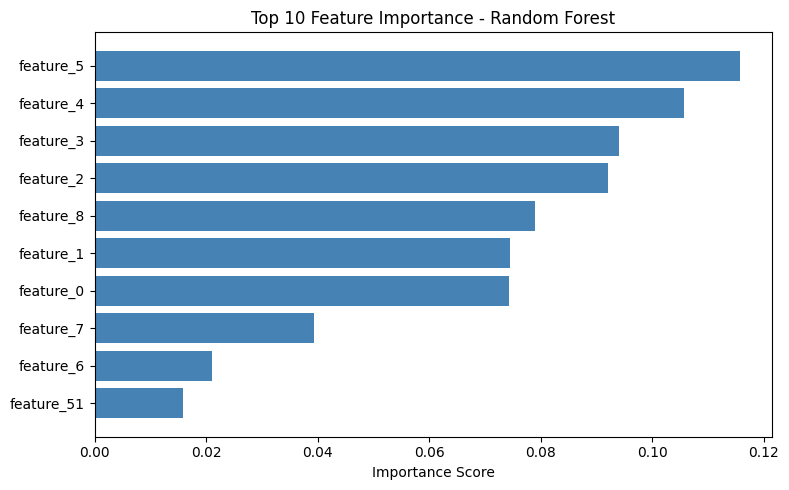

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# --- TRAIN MODEL ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# gunakan model yang sudah dilatih
model_rf = rf  

# --- Ambil feature importance ---
def safe_get_importances(model, X_test=None, y_test=None):
    try:
        # coba ambil feature_importances_
        if hasattr(model, "feature_importances_"):
            return np.array(model.feature_importances_, dtype=float)

        # kalau model dibungkus pipeline / gridsearch
        if hasattr(model, "best_estimator_"):
            return safe_get_importances(model.best_estimator_, X_test, y_test)
        if hasattr(model, "named_steps"):
            for step in model.named_steps.values():
                fi = safe_get_importances(step, X_test, y_test)
                if fi is not None:
                    return fi

        # fallback: permutation_importance
        print("Fallback: menggunakan permutation_importance() ...")
        res = permutation_importance(
            model, X_test, y_test,
            n_repeats=5, random_state=42, n_jobs=-1, scoring="accuracy"
        )
        return np.array(res.importances_mean, dtype=float)
    except Exception as e:
        print("Gagal ambil feature_importances_:", e)
        return None

# --- Jalankan fungsi ---
feature_importance = safe_get_importances(model_rf, X_test, y_test)

if feature_importance is None:
    raise ValueError("Gagal mendapatkan feature importance dari model.")

# --- Ambil nama fitur ---
if hasattr(X_train, "columns"):
    features = list(X_train.columns)
else:
    features = [f"feature_{i}" for i in range(len(feature_importance))]

# --- Sinkronisasi panjang ---
min_len = min(len(features), len(feature_importance))
features = features[:min_len]
feature_importance = feature_importance[:min_len]

# --- Buat dataframe & pastikan kolom numerik ---
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

importance_df["Importance"] = pd.to_numeric(importance_df["Importance"], errors="coerce").fillna(0)

print("Top 10 Feature Importance:")
display(importance_df.head(10))

# --- Visualisasi ---
plt.figure(figsize=(8,5))
plt.barh(
    importance_df["Feature"].head(10),
    importance_df["Importance"].head(10),
    color="steelblue"
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:

mapping = {
    'feature_5': 'interest rate',
    'feature_4': 'dti',
    'feature_3': 'annual income',
    'feature_2': 'installment',
    'feature_8': 'loan amount',
    'feature_1': 'grade',
    'feature_0': 'sub_grade',
    'feature_7': 'open_acc',
    'feature_6': 'revol_bal',
    'feature_51': 'emp_length'
}

# Ganti nama fitur di dataframe
importance_df['Feature Name'] = importance_df['Feature'].map(mapping)

# --- Tampilkan 10 fitur teratas dalam format yang rapi ---
top10 = importance_df.head(10)
for i, row in enumerate(top10.itertuples(), start=1):
    print(f"{i}. {row._3} ({row.Importance:.4f})")  # _3 adalah kolom 'Feature Name'


1. interest rate (0.1157)
2. dti (0.1057)
3. annual income (0.0941)
4. installment (0.0921)
5. loan amount (0.0790)
6. grade (0.0744)
7. sub_grade (0.0742)
8. open_acc (0.0393)
9. revol_bal (0.0211)
10. emp_length (0.0159)
